## Impact of Pre-processing and Post-processing Techniques for Feature Selection on Prediction of Heart Failure Patients Readmission from EHRs.

**Student Name: Oghenekeno F. Eribewe**

**Supervisor: Dr. Kyle Martin**

**Date: 14th, August 2023**

Heart failure is a global pandemic, causing significant morbidity, mortality, and economic burden. Despite 
advancements in cardiology, it remains a leading cause of hospitalization, particularly among the elderly 
(Zhang et al. 2020; Awan et al. 2019). Studies have shown high mortality rates within a year after 
hospitalization for acute heart failure, emphasizing the need for effective prediction and management 
strategies. Furthermore, heart failure is associated with high hospital readmission rates (Zhang et al. 2021; 
Zhang et al. 2020).

##### Predicting Hospital Readmission
Predicting hospital readmission in heart failure patients is crucial for improving care quality, reducing costs, 
and optimizing resource allocation (Rahman et al. 2023). High readmission rates indicate inadequate initial 
care and discharge planning, which can negatively impact patient health and well-being. Predictive models 
can help identify patients at high risk of readmission and allocate resources effectively (Rahman et al. 
2023). However, current prediction abilities are limited, and traditional approaches may not capture 
complex relationships among features (Awan et al. 2019; Mortazavi et al. 2016).


#### Aims & Objectives
The main goal of this research is to evaluate the effectiveness of various pre-processing and post-processing methods and how they influence feature selection. By doing so, we aim to reveal key features that can lead to the development of more accurate prediction models and, ultimately, enhance patient care in heart failure management.

Next, we move on to the implementation of the project requirements...

#### Loading the required packages

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np

# Graphic libraries
import matplotlib.pyplot as plt
import seaborn as sns

# train-test split
from sklearn.model_selection import train_test_split

# Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix

# ignore warnings from pandas
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Dataset
Data Source for Study:

- Database: Patient-specific, freely accessible database

- Origin: PhysioNet data portal (https://physionet.org/content/heart-failure-zigong/1.3/)

- Accessed: 21 June 2023

- References: Goldberger et al. 2000

- Patients: 2008 heart failure patients

- Fields: 167 features

- Hospital: Fourth People’s Hospital of Zigong City, Sichuan, China

- Time Frame: December 2016 to June 2019

- Dataset Authors: Zhang et al. 2020; Zhang et al. 2021

In [2]:
# read in the data

# original dataset
org_data = pd.read_csv("dat.csv")

# revised dataset
df_rev = pd.read_csv("revised_dataset_HF.csv")

In [3]:
# all columns in dataframes
org_columns = pd.DataFrame(org_data.columns)
df_columns = pd.DataFrame(df_rev.columns)

In [4]:
# list of all columns in the revised dataset
display(df_columns)

,0
0,inpatient.number
1,DestinationDischarge
2,admission.ward
3,admission.way
4,occupation
...,...
152,total.hemoglobin
153,GCS
154,dischargeDay
155,ageCat


In [5]:
# dimensions of the datasets
org_data.shape

(2008, 167)

#### Data preparation
- **Initial Analysis and Pre-processing:**

The dataset was thoroughly examined to understand its features and ensure its suitability.
Proper pre-processing was performed using Python to prepare the data.

- **Target Feature Generation:**

The target feature was derived through a conditional aggregation of three distinct features.
These features could have individually served as target variables for various readmission prediction tasks.
The dataset contained "readmission within 28 days," "readmission within 3 months," and "readmission within 6 months."
"Readmission within 28 days" and "readmission within 3 months" were considered equivalent to "readmission within 6 months."
A condition was applied to aggregate records within these features and create the target feature.
Subsequently, the original three features were dropped from the dataset.

- **Feature Selection:**

Eight additional features were discarded due to a high proportion of missing entries (around 90%).
This led to the retention of 157 relevant features.

- **Data Size and Completeness:**

After pre-processing and feature selection, the dataset comprised 1937 records.
71 patient records were excluded from analysis due to a substantial number of missing entries.
This quick and easy data preparation done with excel resulted in a refined dataset with 157 features and 1937 records, enabling us to proceed with proper pre-processing/feature engineering techniques, accurate analysis and predictive modeling.

In [6]:
df_rev.shape

(1937, 157)

### Preprocessing the revised dataset

In [7]:
# working with the revised dataset
df_rev.shape

(1937, 157)

In [8]:
# checking amounts of NA's (missing values) in each field
pd.DataFrame(df_rev.isna().sum())

,0
inpatient.number,0
DestinationDischarge,0
admission.ward,0
admission.way,0
occupation,26
...,...
total.hemoglobin,988
GCS,0
dischargeDay,0
ageCat,0


In [9]:
# dropping irrelevant fields
df_rev.drop("inpatient.number", axis=1, inplace=True)

- **Removing Redundant Patient Numbers:**

The field containing unique patient numbers was eliminated from the dataset.
This step was taken because the patient numbers held no predictive value for model training.


- **Threshold-based Handling of Missing Values:**

To address missing values effectively, a threshold was established.
Fields with non-missing entries with atleast this threshold were identified and retained, dropping all fields with non-missing values below the threshold.
Imputation of missing values will be focused on fields where a reasonable proportion of entries were missing.
This approach ensured that imputation was performed only in fields with a meaningful amount of missing data.

In [10]:
# defining the threshold for the number of non-NaN values required to keep a column
threshold = len(df_rev) - 670  # Keep columns with at least (total rows - 670) non-NaN values

# dropping columns with a number of non-NaN values below the threshold
df_cleaned = df_rev.dropna(axis=1, thresh=threshold)

In [11]:
# checking amounts of NA's (missing values) in each field
df_cleaned.shape

(1937, 116)

We now have 116 features after dropping the features with large amounts of missing entries

In [12]:
df_cleaned["occupation"] = df_cleaned["occupation"].fillna('No Occupation')

### Label  encoding categorical variables
Next, we encode the categorical variables (i.e., transforming the categorical data into numerical values) as many ML algorithms require numerical input data.

In [13]:
# import the label encoding package
from sklearn.preprocessing import LabelEncoder

# identify categorical columns in the DataFrame
object_columns = df_cleaned.select_dtypes(include='object').columns

# converting the data type from object to categorical 
df_cleaned[object_columns] = df_cleaned[object_columns].astype('category')

In [14]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Iterate through each categorical column and label encode the values
for column in object_columns:
    df_cleaned[column] = label_encoder.fit_transform(df_cleaned[column]) 

### Handling missing values in all fields
Next, we try to handle the missing values using the KNNImputer from the sklearn library. The KNNImputer predicts the value of a missing value by observing trends in related columns. It then chooses the best fit value based on the k-Nearest Neighbors algorithm.

In [15]:
from sklearn.impute import KNNImputer

# Identify columns with numerical data (to use for KNN imputation)
numerical_columns = df_cleaned.select_dtypes(include='number').columns

# Create a KNNImputer object with the desired number of neighbors
imputer = KNNImputer(n_neighbors=10)

# Fit the imputer on the dataset and transform it to replace NA values
df_cleaned[numerical_columns] = imputer.fit_transform(df_cleaned[numerical_columns])

In [16]:
df_cleaned.head()

,DestinationDischarge,admission.ward,admission.way,occupation,discharge.department,visit.times,gender,body.temperature,pulse,respiration,...,total.bile.acid,total.protein,cholesterol,low.density.lipoprotein.cholesterol,triglyceride,high.density.lipoprotein.cholesterol,GCS,dischargeDay,ageCat,outcome
0,2.0,0.0,0.0,3.0,0.0,1.0,1.0,36.1,80.0,18.0,...,12.00,52.2,3.473,1.797,0.996,0.989,15.0,16.0,6.0,1.0
1,2.0,0.0,1.0,3.0,0.0,1.0,0.0,36.7,75.0,20.0,...,5.06,66.1,4.500,2.060,0.840,1.450,15.0,14.0,6.0,1.0
2,1.0,0.0,1.0,3.0,0.0,1.0,0.0,36.3,72.0,18.0,...,1.70,69.2,3.920,2.140,1.910,0.960,15.0,7.0,4.0,0.0
3,2.0,0.0,1.0,3.0,3.0,1.0,1.0,36.3,78.0,20.0,...,45.50,57.1,3.427,1.713,1.153,0.978,15.0,10.0,3.0,1.0
4,2.0,0.0,0.0,3.0,0.0,1.0,0.0,37.0,90.0,19.0,...,5.75,79.4,2.850,1.580,1.310,0.850,15.0,5.0,5.0,1.0


In [17]:
pd.DataFrame(df_cleaned.isna().sum())

,0
DestinationDischarge,0
admission.ward,0
admission.way,0
occupation,0
discharge.department,0
...,...
high.density.lipoprotein.cholesterol,0
GCS,0
dischargeDay,0
ageCat,0


We now have no field with any missing values.

### Feature Scaling
Feature scaling is the process of normalizing the range of features in a dataset. Real-world datasets often contain features that are varying in degrees of magnitude, range, and units. Therefore, in order for machine learning models to interpret these features on the same scale, we need to perform feature scaling.
The approach we have opted for in this experiment is the MinMaxScaler from the sklearn library which performs a linear transformation on the original data. This technique gets all the scaled data in the range (0, 1).  

In [18]:
col_names = df_cleaned.columns

In [19]:
# scaling the features to have min = 0 & max = 1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_cleaned = scaler.fit_transform(df_cleaned)

In [20]:
df_cleaned = pd.DataFrame(df_cleaned)
df_cleaned.columns = col_names

In [21]:
pd.DataFrame(df_cleaned.describe())

,DestinationDischarge,admission.ward,admission.way,occupation,discharge.department,visit.times,gender,body.temperature,pulse,respiration,...,total.bile.acid,total.protein,cholesterol,low.density.lipoprotein.cholesterol,triglyceride,high.density.lipoprotein.cholesterol,GCS,dischargeDay,ageCat,outcome
count,1937.000000,1937.000000,1937.000000,1937.000000,1937.000000,1937.000000,1937.000000,1937.000000,1937.000000,1937.000000,...,1937.000000,1937.000000,1937.000000,1937.000000,1937.000000,1937.000000,1937.000000,1937.000000,1937.000000,1937.000000
mean,0.622784,0.139563,0.523490,0.604233,0.066426,0.023103,0.418172,0.202530,0.430179,0.529656,...,0.049299,0.395252,0.285745,0.248136,0.039839,0.397029,0.991869,0.069344,0.716277,0.398554
std,0.187327,0.298589,0.499577,0.111353,0.186351,0.091697,0.493386,0.062241,0.108754,0.047931,...,0.070108,0.120870,0.119001,0.120215,0.044109,0.123507,0.065514,0.065376,0.164166,0.489727
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.666667,0.000000,0.000000,0.600000,0.000000,0.000000,0.000000,0.171429,0.353535,0.500000,...,0.018225,0.317568,0.207159,0.168317,0.021048,0.316176,1.000000,0.040984,0.571429,0.000000
50%,0.666667,0.000000,1.000000,0.600000,0.000000,0.000000,0.000000,0.185714,0.414141,0.527778,...,0.032569,0.390203,0.272273,0.232673,0.031366,0.386029,1.000000,0.057377,0.714286,0.000000
75%,0.666667,0.000000,1.000000,0.600000,0.000000,0.000000,1.000000,0.214286,0.494949,0.527778,...,0.052557,0.462838,0.346591,0.310231,0.044986,0.463235,1.000000,0.073770,0.857143,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Splitting the dataset (predictors and target variables)

In [22]:
# Extract the target variable and store it in a separate variable if needed
Y = df_cleaned['outcome']

# Drop the target variable from the DataFrame
X = df_cleaned.drop(columns='outcome')

In [23]:
X.shape, Y.shape

((1937, 115), (1937,))

In [24]:
Y.value_counts()

0.0    1165
1.0     772
Name: outcome, dtype: int64

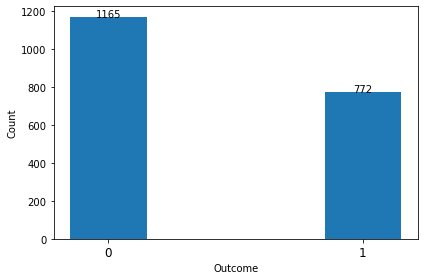

In [25]:
fig, ax = plt.subplots()

x = [0, 1]
y = [1165, 772]

ax.bar(x, y, width=0.3)
ax.set_xlabel('Outcome')
ax.set_ylabel('Count')
ax.set_xticks([0,1])
ax.set_xticklabels([0,1], fontsize=12)

for index, value in enumerate(y):
    plt.text(x=int(index), y=value+1, s=str(value), ha='center')

plt.tight_layout()

The imbalance in the binary class is about a 60%(1165 patients not readmitted within 6 months) - 40%(772 patients readmitted within 6 months) ratio split.

### Train-test split

In [26]:
# building train/test datasets on a 70/30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=123, stratify=Y, shuffle=True)
X_train.shape, X_test.shape

((1355, 115), (582, 115))

In [27]:
y_test.value_counts()

0.0    350
1.0    232
Name: outcome, dtype: int64

### Baseline model: Decision tree, Random forest, Gradient boosting, and Multilayer perceptron classifier with all features

In [28]:
# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

**F1-Score:** In healthcare prediction tasks, the F1-score is valuable because it considers both precision and recall, making it suitable for imbalanced datasets. It provides a balanced measure of the model's performance, particularly in situations where one class is dominant over the other.

**Accuracy:** Accuracy is commonly used for healthcare prediction, but it can be misleading in imbalanced datasets. It ignores the impact of misclassifying critical cases and is not suitable when classes have unequal proportions. Precision, Recall, and F1-score offer more informative insights for model performance in healthcare scenarios. Since f1-score takes into account both precesion and recall, we utilize f1.

#### Decision Tree

In [29]:
# loading the DT package from sklearn
from sklearn.tree import DecisionTreeClassifier

# initiating the classifier
clf_dt = DecisionTreeClassifier(random_state=123)

# fit the classifier to the training set
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=123)

##### Evaluation

In [30]:
y_pred_dt = clf_dt.predict(X_test)

acc_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

acc_dt, f1_dt

(0.5240549828178694, 0.4118895966029724)

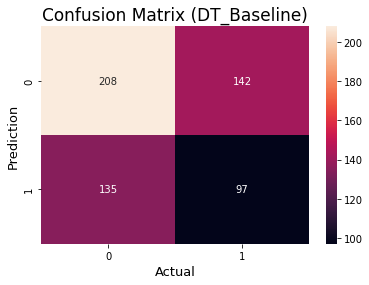

In [165]:
# confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
#Plot the confusion matrix.
sns.heatmap(cm_dt,
            annot=True,
            fmt='g',
            xticklabels=['0','1'],
            yticklabels=['0','1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix (DT_Baseline)',fontsize=17)
plt.show()

In [32]:
print(classification_report(y_test, y_pred_dt, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.61      0.59      0.60       350
           1       0.41      0.42      0.41       232

    accuracy                           0.52       582
   macro avg       0.51      0.51      0.51       582
weighted avg       0.53      0.52      0.53       582



#### Random Forest

In [33]:
# loading the rf package from sklearn
from sklearn.ensemble import RandomForestClassifier

# initiating the classifier
clf_rf = RandomForestClassifier(random_state=123)

# fit the classifier to the training set
clf_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

##### Evaluation

In [34]:
y_pred_rf = clf_rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

acc_rf, f1_rf

(0.6254295532646048, 0.3699421965317919)

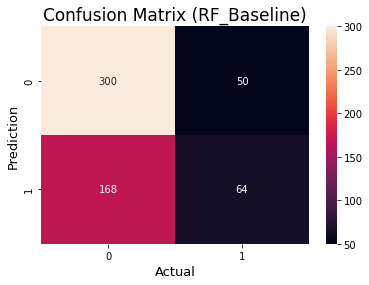

In [35]:
# confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
#Plot the confusion matrix.
sns.heatmap(cm_rf,
            annot=True,
            fmt='g',
            xticklabels=['0','1'],
            yticklabels=['0','1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix (RF_Baseline)',fontsize=17)
plt.show()

In [36]:
print(classification_report(y_test, y_pred_rf, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.64      0.86      0.73       350
           1       0.56      0.28      0.37       232

    accuracy                           0.63       582
   macro avg       0.60      0.57      0.55       582
weighted avg       0.61      0.63      0.59       582



#### Gradient Boosting Classifier

In [37]:
# loading the svc package from sklearn
from sklearn.ensemble import GradientBoostingClassifier

# initiating the classifier
clf_gb = GradientBoostingClassifier(random_state=123)

# fit the classifier to the training data
clf_gb.fit(X_train, y_train)

GradientBoostingClassifier(random_state=123)

##### Evaluation

In [38]:
y_pred_gb = clf_gb.predict(X_test)

acc_gb = accuracy_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)

acc_gb, f1_gb

(0.6219931271477663, 0.4300518134715026)

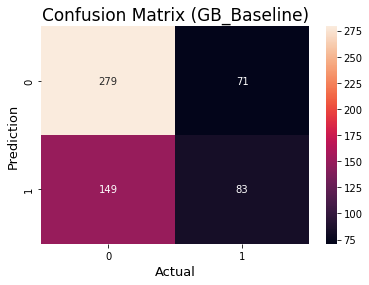

In [166]:
# confusion matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
#Plot the confusion matrix.
sns.heatmap(cm_gb,
            annot=True,
            fmt='g',
            xticklabels=['0','1'],
            yticklabels=['0','1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix (GB_Baseline)',fontsize=17)
plt.show()

In [40]:
print(classification_report(y_test, y_pred_gb, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.65      0.80      0.72       350
           1       0.54      0.36      0.43       232

    accuracy                           0.62       582
   macro avg       0.60      0.58      0.57       582
weighted avg       0.61      0.62      0.60       582



#### Multilayer Perceptron Classifier

In [41]:
# loading the mlp package from sklearn
from sklearn.neural_network import MLPClassifier

# initiating the classifier
clf_mlp = MLPClassifier(random_state=123)

# fit the classifier to the training data
clf_mlp.fit(X_train, y_train)

MLPClassifier(random_state=123)

##### Evaluation

In [42]:
y_pred_mlp = clf_mlp.predict(X_test)

acc_mlp = accuracy_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)

acc_mlp, f1_mlp

(0.6151202749140894, 0.44)

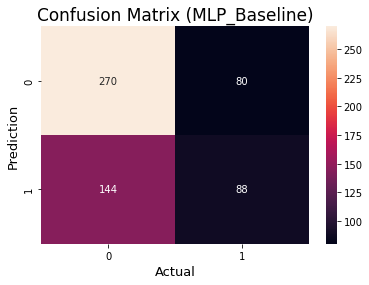

In [167]:
# confusion matrix
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
#Plot the confusion matrix.
sns.heatmap(cm_mlp,
            annot=True,
            fmt='g',
            xticklabels=['0','1'],
            yticklabels=['0','1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix (MLP_Baseline)',fontsize=17)
plt.show()

In [44]:
print(classification_report(y_test, y_pred_gb, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.65      0.80      0.72       350
           1       0.54      0.36      0.43       232

    accuracy                           0.62       582
   macro avg       0.60      0.58      0.57       582
weighted avg       0.61      0.62      0.60       582



### Feature Selection (Pre-processing techniques)

#### Correlation Analysis (Pearson)/Pairwise correlation

In [45]:
# using pearson correlation to identify features that are highly correlated
corr_mat = X_train.corr(method='pearson')

# the amount of features makes it hard to analyse

In [46]:
def corr_analysis(dataset, threshld):
  col_corr = set() # list of all the correlated features

  corr_matrix = dataset.corr(method='pearson') # using the pearson correlation method

  for i in range(len(corr_matrix.columns)):

        for j in range(i):

            if abs(corr_matrix.iloc[i, j]) > threshld: # we are interested in absolute coeff value

                # getting the name of column
                colname = corr_matrix.columns[i]

                # adding the feature to the list
                col_corr.add(colname)

  return col_corr

In [47]:
# applying the function on the training set
corr_feats = corr_analysis(X_train, 0.7)

# convert the set into a list
corr_feats = list(corr_feats)

# number of features highly correlated
len(corr_feats)

22

In [48]:
# list of all features that are highly correlated
corr_feats

['total.bilirubin',
 'eosinophil.count',
 'basophil.count',
 'direct.bilirubin',
 'platelet.hematocrit',
 'cystatin',
 'creatine.kinase.isoenzyme',
 'globulin',
 'mean.hemoglobin.volume',
 'lactate.dehydrogenase',
 'hemoglobin',
 'verbal.response',
 'movement',
 'prothrombin.time.ratio',
 'GCS',
 'map',
 'respiratory.support.',
 'neutrophil.count',
 'total.protein',
 'low.density.lipoprotein.cholesterol',
 'hematocrit',
 'sodium']

In [49]:
# creating new versions of the train and test set by dropping the highly correlated features
X_train_v1, X_test_v1 = X_train.drop(corr_feats, axis=1), X_test.drop(corr_feats, axis=1)

X_train_v1.shape, X_test_v1.shape

((1355, 93), (582, 93))

##### Re-training the models(correlation analysis)

In [50]:
# DT Classifier
clf_dt_corr = DecisionTreeClassifier(random_state=123)

clf_dt_corr.fit(X_train_v1, y_train)

y_pred_dt_corr = clf_dt_corr.predict(X_test_v1)

# evaluation
acc_dt_corr = accuracy_score(y_test, y_pred_dt_corr)
f1_dt_corr = f1_score(y_test, y_pred_dt_corr)

acc_dt_corr, f1_dt_corr

(0.5773195876288659, 0.4788135593220339)

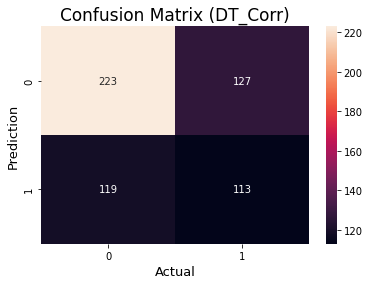

In [51]:
# confusion matrix
cm_dt_corr = confusion_matrix(y_test, y_pred_dt_corr)

#Plot the confusion matrix.
sns.heatmap(cm_dt_corr,
            annot=True,
            fmt='g',
            xticklabels=['0','1'],
            yticklabels=['0','1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix (DT_Corr)',fontsize=17)
plt.show()

In [52]:
print(classification_report(y_test, y_pred_dt_corr, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.65      0.64      0.64       350
           1       0.47      0.49      0.48       232

    accuracy                           0.58       582
   macro avg       0.56      0.56      0.56       582
weighted avg       0.58      0.58      0.58       582



In [53]:
# RandomForest Classifier
clf_rf_corr = RandomForestClassifier(random_state=123)

clf_rf_corr.fit(X_train_v1, y_train)

y_pred_rf_corr = clf_rf_corr.predict(X_test_v1)

# evaluation
acc_rf_corr = accuracy_score(y_test, y_pred_rf_corr)
f1_rf_corr = f1_score(y_test, y_pred_rf_corr)

acc_rf_corr, f1_rf_corr

(0.6357388316151202, 0.35757575757575755)

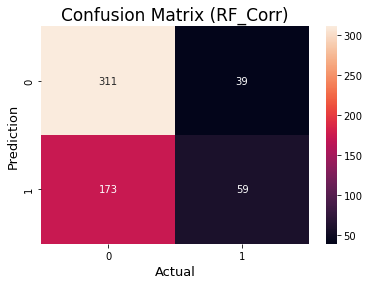

In [54]:
# confusion matrix
cm_rf_corr = confusion_matrix(y_test, y_pred_rf_corr)

#Plot the confusion matrix.
sns.heatmap(cm_rf_corr,
            annot=True,
            fmt='g',
            xticklabels=['0','1'],
            yticklabels=['0','1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix (RF_Corr)',fontsize=17)
plt.show()

In [55]:
print(classification_report(y_test, y_pred_rf_corr, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.64      0.89      0.75       350
           1       0.60      0.25      0.36       232

    accuracy                           0.64       582
   macro avg       0.62      0.57      0.55       582
weighted avg       0.63      0.64      0.59       582



In [56]:
# GBClassifier
clf_gb_corr = GradientBoostingClassifier(random_state=123)

clf_gb_corr.fit(X_train_v1, y_train)

y_pred_gb_corr = clf_gb_corr.predict(X_test_v1)

# evaluation
acc_gb_corr = accuracy_score(y_test, y_pred_gb_corr)
f1_gb_corr = f1_score(y_test, y_pred_gb_corr)

acc_gb_corr, f1_gb_corr

(0.6288659793814433, 0.4404145077720207)

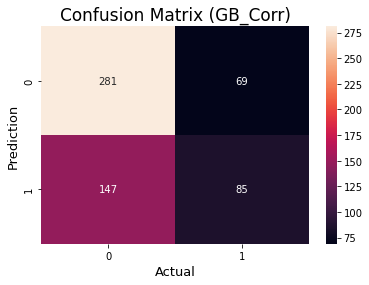

In [57]:
# confusion matrix
cm_gb_corr = confusion_matrix(y_test, y_pred_gb_corr)

#Plot the confusion matrix.
sns.heatmap(cm_gb_corr,
            annot=True,
            fmt='g',
            xticklabels=['0','1'],
            yticklabels=['0','1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix (GB_Corr)',fontsize=17)
plt.show()

In [58]:
print(classification_report(y_test, y_pred_gb_corr, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.66      0.80      0.72       350
           1       0.55      0.37      0.44       232

    accuracy                           0.63       582
   macro avg       0.60      0.58      0.58       582
weighted avg       0.61      0.63      0.61       582



In [59]:
# MLPClassifier
clf_mlp_corr = MLPClassifier(random_state=123)

clf_mlp_corr.fit(X_train_v1, y_train)

y_pred_mlp_corr = clf_mlp_corr.predict(X_test_v1)

# evaluation
acc_mlp_corr = accuracy_score(y_test, y_pred_mlp_corr)
f1_mlp_corr = f1_score(y_test, y_pred_mlp_corr)

acc_mlp_corr, f1_mlp_corr

(0.6219931271477663, 0.48113207547169806)

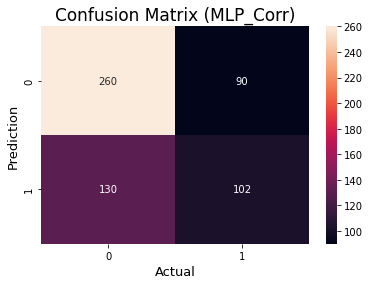

In [60]:
# confusion matrix
cm_mlp_corr = confusion_matrix(y_test, y_pred_mlp_corr)

#Plot the confusion matrix.
sns.heatmap(cm_mlp_corr,
            annot=True,
            fmt='g',
            xticklabels=['0','1'],
            yticklabels=['0','1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix (MLP_Corr)',fontsize=17)
plt.show()


In [61]:
print(classification_report(y_test, y_pred_mlp_corr, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.67      0.74      0.70       350
           1       0.53      0.44      0.48       232

    accuracy                           0.62       582
   macro avg       0.60      0.59      0.59       582
weighted avg       0.61      0.62      0.61       582



#### Mutual Information Gain (K-best features)

In [62]:
# loading required packages from sklearn
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

# determine the mutual information
mutual_info = mutual_info_classif(X_train, y_train)

In [63]:
type(mutual_info)

numpy.ndarray

In [64]:
# turn the array into a series so as to access the index
mutual_info = pd.Series(mutual_info)

# assign the columns in the training set as the index
mutual_info.index = X_train.columns

# sorting in descending order (highes to lowest)
mutual_info.sort_values(ascending=False)

cystatin                                                   0.039266
urea                                                       0.037374
mean.corpuscular.volume                                    0.036805
prothrombin.time.ratio                                     0.036465
mean.hemoglobin.volume                                     0.031337
                                                             ...   
outcome.during.hospitalization                             0.000000
oxygen.inhalation                                          0.000000
respiratory.support.                                       0.000000
eye.opening                                                0.000000
standard.deviation.of.red.blood.cell.distribution.width    0.000000
Length: 115, dtype: float64

<AxesSubplot:>

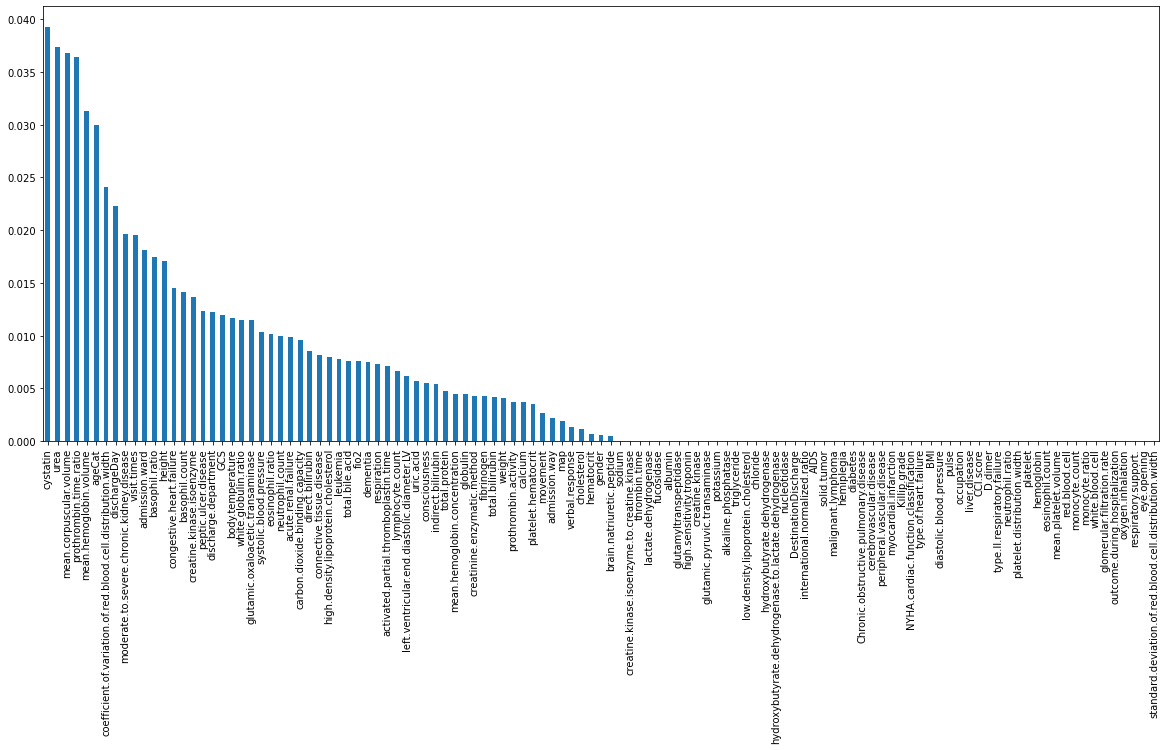

In [65]:
# plot of the ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [66]:
# Next we select the top 58 important features
sel_top_cols = SelectKBest(mutual_info_classif, k=58)
sel_top_cols.fit(X_train, y_train)
col_names_IG = X_train.columns[sel_top_cols.get_support()]
len(col_names_IG)

58

In [67]:
# creating new versions of the train and test set by using the selected features
X_train_v2, X_test_v2 = X_train[col_names_IG], X_test[col_names_IG]

X_train_v2.shape, X_test_v2.shape

((1355, 58), (582, 58))

##### Re-training the models(Mutual Information Gain)

In [68]:
# DT Classifier
clf_dt_IG = DecisionTreeClassifier(random_state=123)

clf_dt_IG.fit(X_train_v2, y_train)

y_pred_dt_IG = clf_dt_IG.predict(X_test_v2)

# evaluation
acc_dt_IG = accuracy_score(y_test, y_pred_dt_IG)
f1_dt_IG = f1_score(y_test, y_pred_dt_IG)

acc_dt_IG, f1_dt_IG

(0.5103092783505154, 0.39490445859872614)

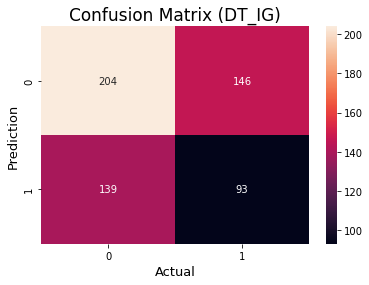

In [69]:
# confusion matrix
cm_dt_IG = confusion_matrix(y_test, y_pred_dt_IG)

#Plot the confusion matrix.
sns.heatmap(cm_dt_IG,
            annot=True,
            fmt='g',
            xticklabels=['0','1'],
            yticklabels=['0','1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix (DT_IG)',fontsize=17)
plt.show()

In [70]:
print(classification_report(y_test, y_pred_dt_IG, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.59      0.58      0.59       350
           1       0.39      0.40      0.39       232

    accuracy                           0.51       582
   macro avg       0.49      0.49      0.49       582
weighted avg       0.51      0.51      0.51       582



In [71]:
# RandomForest Classifier
clf_rf_IG = RandomForestClassifier(random_state=123)

clf_rf_IG.fit(X_train_v2, y_train)

y_pred_rf_IG = clf_rf_IG.predict(X_test_v2)

# evaluation
acc_rf_IG = accuracy_score(y_test, y_pred_rf_IG)
f1_rf_IG = f1_score(y_test, y_pred_rf_IG)

acc_rf_IG, f1_rf_IG

(0.6305841924398625, 0.3657817109144542)

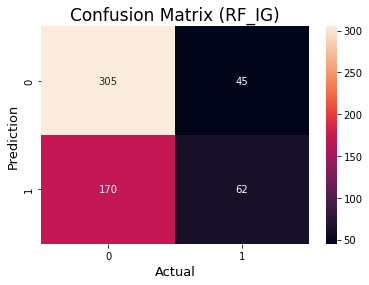

In [72]:
# confusion matrix
cm_rf_IG = confusion_matrix(y_test, y_pred_rf_IG)

#Plot the confusion matrix.
sns.heatmap(cm_rf_IG,
            annot=True,
            fmt='g',
            xticklabels=['0','1'],
            yticklabels=['0','1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix (RF_IG)',fontsize=17)
plt.show()

In [73]:
print(classification_report(y_test, y_pred_rf_IG, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.64      0.87      0.74       350
           1       0.58      0.27      0.37       232

    accuracy                           0.63       582
   macro avg       0.61      0.57      0.55       582
weighted avg       0.62      0.63      0.59       582



In [74]:
# GBClassifier
clf_gb_IG = GradientBoostingClassifier(random_state=123)

clf_gb_IG.fit(X_train_v2, y_train)
y_pred_gb_IG = clf_gb_IG.predict(X_test_v2)

# evaluation
acc_gb_IG = accuracy_score(y_test, y_pred_gb_IG)
f1_gb_IG = f1_score(y_test, y_pred_gb_IG)

acc_gb_IG, f1_gb_IG

(0.6443298969072165, 0.4759493670886076)

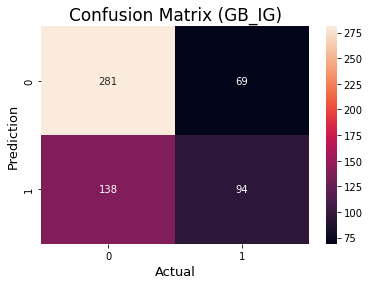

In [75]:
# confusion matrix
cm_gb_IG = confusion_matrix(y_test, y_pred_gb_IG)

#Plot the confusion matrix.
sns.heatmap(cm_gb_IG,
            annot=True,
            fmt='g',
            xticklabels=['0','1'],
            yticklabels=['0','1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix (GB_IG)',fontsize=17)
plt.show()

In [76]:
print(classification_report(y_test, y_pred_gb_IG, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73       350
           1       0.58      0.41      0.48       232

    accuracy                           0.64       582
   macro avg       0.62      0.60      0.60       582
weighted avg       0.63      0.64      0.63       582



In [77]:
# MLPClassifier
clf_mlp_IG = MLPClassifier(random_state=123)

clf_mlp_IG.fit(X_train_v2, y_train)

y_pred_mlp_IG = clf_mlp_IG.predict(X_test_v2)

# evaluation
acc_mlp_IG = accuracy_score(y_test, y_pred_mlp_IG)
f1_mlp_IG = f1_score(y_test, y_pred_mlp_IG)

acc_mlp_IG, f1_mlp_IG

(0.6151202749140894, 0.4885844748858447)

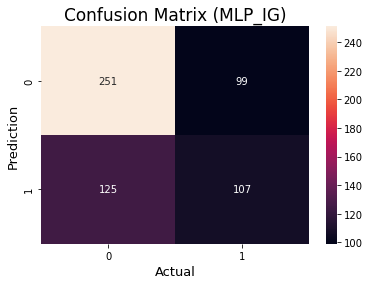

In [78]:
# confusion matrix
cm_mlp_IG = confusion_matrix(y_test, y_pred_mlp_IG)

#Plot the confusion matrix.
sns.heatmap(cm_mlp_IG,
            annot=True,
            fmt='g',
            xticklabels=['0','1'],
            yticklabels=['0','1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix (MLP_IG)',fontsize=17)
plt.show()

In [79]:
print(classification_report(y_test, y_pred_mlp_IG, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.67      0.72      0.69       350
           1       0.52      0.46      0.49       232

    accuracy                           0.62       582
   macro avg       0.59      0.59      0.59       582
weighted avg       0.61      0.62      0.61       582



#### Variance Threshold Feature Selection

In [80]:
### It will zero variance features
from sklearn.feature_selection import VarianceThreshold
var_thres=VarianceThreshold(threshold=0.01)
var_thres.fit(X_train)

VarianceThreshold(threshold=0.01)

In [81]:
#var_thres.get_support()

In [82]:
X_train.columns[var_thres.get_support()]

Index(['DestinationDischarge', 'admission.ward', 'admission.way', 'occupation',
       'discharge.department', 'gender', 'pulse', 'type.of.heart.failure',
       'NYHA.cardiac.function.classification', 'Killip.grade',
       'myocardial.infarction', 'congestive.heart.failure',
       'peripheral.vascular.disease', 'cerebrovascular.disease', 'dementia',
       'Chronic.obstructive.pulmonary.disease', 'peptic.ulcer.disease',
       'diabetes', 'moderate.to.severe.chronic.kidney.disease', 'solid.tumor',
       'liver.disease', 'CCI.score', 'type.II.respiratory.failure',
       'respiratory.support.', 'oxygen.inhalation',
       'left.ventricular.end.diastolic.diameter.LV',
       'outcome.during.hospitalization', 'urea', 'uric.acid',
       'glomerular.filtration.rate', 'white.blood.cell', 'monocyte.count',
       'red.blood.cell',
       'coefficient.of.variation.of.red.blood.cell.distribution.width',
       'mean.corpuscular.volume', 'hematocrit', 'mean.hemoglobin.volume',
       'mean.

In [83]:
constant_columns = [column for column in X_train.columns
                    if column not in X_train.columns[var_thres.get_support()]]

print(len(constant_columns))

57


In [84]:
# creating new versions of the train and test set by dropping the constant features
X_train_v3, X_test_v3 = X_train.drop(constant_columns,axis=1), X_test.drop(constant_columns,axis=1)

X_train_v3.shape, X_test_v3.shape

((1355, 58), (582, 58))

##### Re-training the models(Variance Threshold)

In [85]:
# DT Classifier
clf_dt_vt = DecisionTreeClassifier(random_state=123)

clf_dt_vt.fit(X_train_v3, y_train)

y_pred_dt_vt = clf_dt_vt.predict(X_test_v3)

# evaluation
acc_dt_vt = accuracy_score(y_test, y_pred_dt_vt)
f1_dt_vt = f1_score(y_test, y_pred_dt_vt)

acc_dt_vt, f1_dt_vt

(0.5343642611683849, 0.44580777096114516)

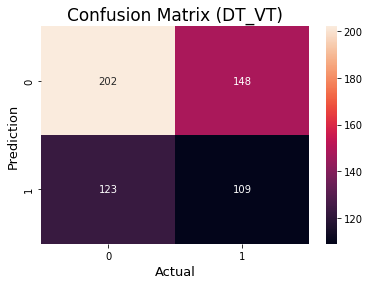

In [86]:
# confusion matrix
cm_dt_vt = confusion_matrix(y_test, y_pred_dt_vt)

#Plot the confusion matrix.
sns.heatmap(cm_dt_vt,
            annot=True,
            fmt='g',
            xticklabels=['0','1'],
            yticklabels=['0','1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix (DT_VT)',fontsize=17)
plt.show()

In [87]:
print(classification_report(y_test, y_pred_dt_vt, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.62      0.58      0.60       350
           1       0.42      0.47      0.45       232

    accuracy                           0.53       582
   macro avg       0.52      0.52      0.52       582
weighted avg       0.54      0.53      0.54       582



In [88]:
# RandomForest Classifier
clf_rf_vt = RandomForestClassifier(random_state=123)

clf_rf_vt.fit(X_train_v3, y_train)

y_pred_rf_vt = clf_rf_vt.predict(X_test_v3)

# evaluation
acc_rf_vt = accuracy_score(y_test, y_pred_rf_vt)
f1_rf_vt = f1_score(y_test, y_pred_rf_vt)

acc_rf_vt, f1_rf_vt

(0.6323024054982818, 0.3515151515151515)

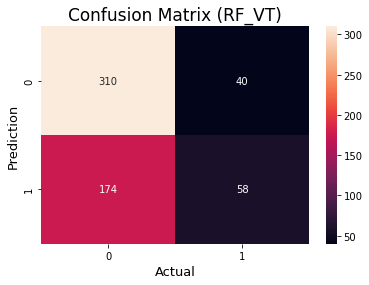

In [89]:
# confusion matrix
cm_rf_vt = confusion_matrix(y_test, y_pred_rf_vt)

#Plot the confusion matrix.
sns.heatmap(cm_rf_vt,
            annot=True,
            fmt='g',
            xticklabels=['0','1'],
            yticklabels=['0','1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix (RF_VT)',fontsize=17)
plt.show()

In [90]:
print(classification_report(y_test, y_pred_rf_vt, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.64      0.89      0.74       350
           1       0.59      0.25      0.35       232

    accuracy                           0.63       582
   macro avg       0.62      0.57      0.55       582
weighted avg       0.62      0.63      0.59       582



In [91]:
# GBClassifier
clf_gb_vt = GradientBoostingClassifier(random_state=123)

clf_gb_vt.fit(X_train_v3, y_train)
y_pred_gb_vt = clf_gb_vt.predict(X_test_v3)

# evaluation
acc_gb_vt = accuracy_score(y_test, y_pred_gb_vt)
f1_gb_vt = f1_score(y_test, y_pred_gb_vt)

acc_gb_vt, f1_gb_vt

(0.6099656357388317, 0.41943734015345263)

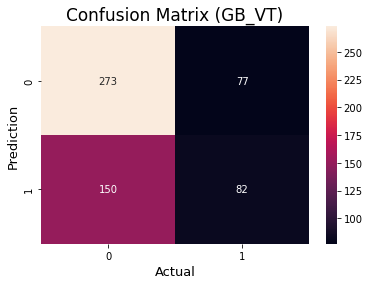

In [92]:
# confusion matrix
cm_gb_vt = confusion_matrix(y_test, y_pred_gb_vt)

#Plot the confusion matrix.
sns.heatmap(cm_gb_vt,
            annot=True,
            fmt='g',
            xticklabels=['0','1'],
            yticklabels=['0','1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix (GB_VT)',fontsize=17)
plt.show()

In [93]:
print(classification_report(y_test, y_pred_gb_vt, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.65      0.78      0.71       350
           1       0.52      0.35      0.42       232

    accuracy                           0.61       582
   macro avg       0.58      0.57      0.56       582
weighted avg       0.59      0.61      0.59       582



In [94]:
# MLPClassifier
clf_mlp_vt = MLPClassifier(random_state=123)

clf_mlp_vt.fit(X_train_v3, y_train)

y_pred_mlp_vt = clf_mlp_vt.predict(X_test_v3)

# evaluation
acc_mlp_vt = accuracy_score(y_test, y_pred_mlp_vt)
f1_mlp_vt = f1_score(y_test, y_pred_mlp_vt)

acc_mlp_vt, f1_mlp_vt

(0.6219931271477663, 0.4977168949771689)

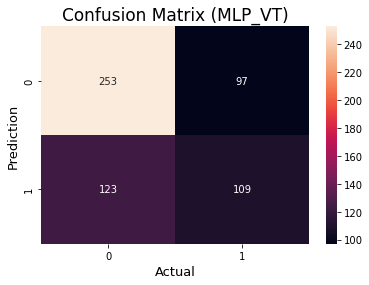

In [95]:
# confusion matrix
cm_mlp_vt = confusion_matrix(y_test, y_pred_mlp_vt)

#Plot the confusion matrix.
sns.heatmap(cm_mlp_vt,
            annot=True,
            fmt='g',
            xticklabels=['0','1'],
            yticklabels=['0','1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix (MLP_VT)',fontsize=17)
plt.show()

In [96]:
print(classification_report(y_test, y_pred_mlp_vt, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.67      0.72      0.70       350
           1       0.53      0.47      0.50       232

    accuracy                           0.62       582
   macro avg       0.60      0.60      0.60       582
weighted avg       0.62      0.62      0.62       582



### Feature Selection (Post-processing techniques)

#### Recursive Feature Elimination

In [97]:
from sklearn.feature_selection import RFE

##### Re-training the models(Recursive Feature Elimination)

In [98]:
# DT Classifier
clf_dt_rfe = DecisionTreeClassifier(random_state=123)

rfe_dt = RFE(clf_dt_rfe, n_features_to_select=60)
rfe_dt.fit(X_train, y_train)

y_pred_dt_rfe = rfe_dt.predict(X_test)

# evaluation
acc_dt_rfe = accuracy_score(y_test, y_pred_dt_rfe)
f1_dt_rfe = f1_score(y_test, y_pred_dt_rfe)

acc_dt_rfe, f1_dt_rfe

(0.5326460481099656, 0.4356846473029045)

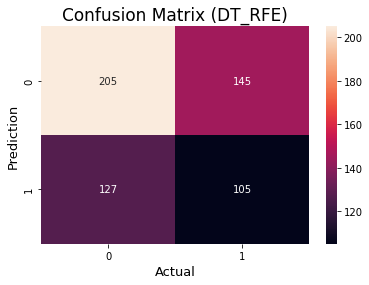

In [99]:
# confusion matrix
cm_dt_rfe = confusion_matrix(y_test, y_pred_dt_rfe)

#Plot the confusion matrix.
sns.heatmap(cm_dt_rfe,
            annot=True,
            fmt='g',
            xticklabels=['0','1'],
            yticklabels=['0','1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix (DT_RFE)',fontsize=17)
plt.show()

In [100]:
print(classification_report(y_test, y_pred_dt_rfe, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.62      0.59      0.60       350
           1       0.42      0.45      0.44       232

    accuracy                           0.53       582
   macro avg       0.52      0.52      0.52       582
weighted avg       0.54      0.53      0.54       582



In [101]:
 print('Best features :', X_train.columns[rfe_dt.support_])

Best features : Index(['occupation', 'pulse', 'systolic.blood.pressure', 'map', 'weight',
       'height', 'congestive.heart.failure', 'diabetes',
       'creatinine.enzymatic.method', 'urea', 'uric.acid', 'cystatin',
       'white.blood.cell', 'monocyte.ratio', 'monocyte.count',
       'red.blood.cell',
       'coefficient.of.variation.of.red.blood.cell.distribution.width',
       'standard.deviation.of.red.blood.cell.distribution.width',
       'mean.corpuscular.volume', 'lymphocyte.count',
       'mean.hemoglobin.concentration', 'mean.platelet.volume',
       'basophil.ratio', 'basophil.count', 'hemoglobin', 'platelet',
       'neutrophil.ratio', 'D.dimer', 'activated.partial.thromboplastin.time',
       'thrombin.time', 'prothrombin.activity', 'prothrombin.time.ratio',
       'fibrinogen', 'high.sensitivity.troponin',
       'carbon.dioxide.binding.capacity', 'calcium', 'potassium', 'chloride',
       'sodium', 'creatine.kinase.isoenzyme.to.creatine.kinase',
       'hydroxybutyrate

In [102]:
# RandomForest Classifier
clf_rf_rfe = RandomForestClassifier(random_state=123)

rfe_rf = RFE(clf_rf_rfe, n_features_to_select=60)
rfe_rf.fit(X_train, y_train)

y_pred_rf_rfe = rfe_rf.predict(X_test)

# evaluation
acc_rf_rfe = accuracy_score(y_test, y_pred_rf_rfe)
f1_rf_rfe = f1_score(y_test, y_pred_rf_rfe)

acc_rf_rfe, f1_rf_rfe

(0.6323024054982818, 0.33540372670807456)

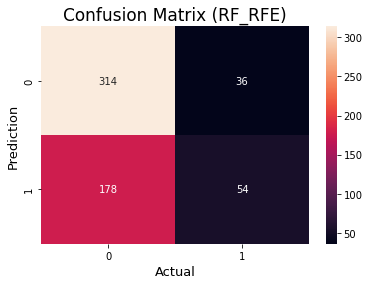

In [103]:
# confusion matrix
cm_rf_rfe = confusion_matrix(y_test, y_pred_rf_rfe)

#Plot the confusion matrix.
sns.heatmap(cm_rf_rfe,
            annot=True,
            fmt='g',
            xticklabels=['0','1'],
            yticklabels=['0','1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix (RF_RFE)',fontsize=17)
plt.show()

In [104]:
print(classification_report(y_test, y_pred_rf_rfe, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.64      0.90      0.75       350
           1       0.60      0.23      0.34       232

    accuracy                           0.63       582
   macro avg       0.62      0.56      0.54       582
weighted avg       0.62      0.63      0.58       582



In [105]:
 print('Best features :', X_train.columns[rfe_rf.support_])

Best features : Index(['pulse', 'systolic.blood.pressure', 'map', 'weight', 'BMI',
       'left.ventricular.end.diastolic.diameter.LV',
       'creatinine.enzymatic.method', 'urea', 'uric.acid',
       'glomerular.filtration.rate', 'cystatin', 'white.blood.cell',
       'monocyte.ratio', 'red.blood.cell',
       'coefficient.of.variation.of.red.blood.cell.distribution.width',
       'standard.deviation.of.red.blood.cell.distribution.width',
       'mean.corpuscular.volume', 'lymphocyte.count', 'mean.hemoglobin.volume',
       'mean.hemoglobin.concentration', 'mean.platelet.volume',
       'eosinophil.ratio', 'platelet', 'platelet.hematocrit',
       'neutrophil.ratio', 'neutrophil.count', 'D.dimer',
       'international.normalized.ratio',
       'activated.partial.thromboplastin.time', 'thrombin.time',
       'prothrombin.activity', 'fibrinogen', 'high.sensitivity.troponin',
       'carbon.dioxide.binding.capacity', 'calcium', 'potassium', 'chloride',
       'sodium', 'hydroxybutyrate

In [106]:
# GBClassifier
clf_gb_rfe = GradientBoostingClassifier(random_state=123)

rfe_gb = RFE(clf_gb_rfe, n_features_to_select=60)
rfe_gb.fit(X_train, y_train)

y_pred_gb_rfe = rfe_gb.predict(X_test)

# evaluation
acc_gb_rfe = accuracy_score(y_test, y_pred_gb_rfe)
f1_gb_rfe = f1_score(y_test, y_pred_gb_rfe)

acc_gb_rfe, f1_gb_rfe

(0.627147766323024, 0.4392764857881136)

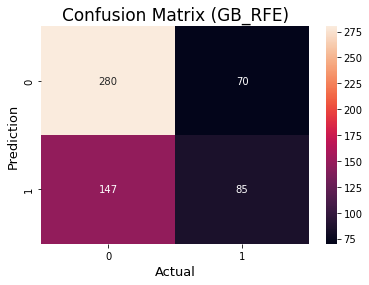

In [107]:
# confusion matrix
cm_gb_rfe = confusion_matrix(y_test, y_pred_gb_rfe)

#Plot the confusion matrix.
sns.heatmap(cm_gb_rfe,
            annot=True,
            fmt='g',
            xticklabels=['0','1'],
            yticklabels=['0','1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix (GB_RFE)',fontsize=17)
plt.show()

In [108]:
print(classification_report(y_test, y_pred_gb_rfe, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.66      0.80      0.72       350
           1       0.55      0.37      0.44       232

    accuracy                           0.63       582
   macro avg       0.60      0.58      0.58       582
weighted avg       0.61      0.63      0.61       582



In [109]:
 print('Best features :', X_train.columns[rfe_gb.support_])

Best features : Index(['occupation', 'pulse', 'systolic.blood.pressure', 'map', 'weight',
       'height', 'BMI', 'type.of.heart.failure',
       'NYHA.cardiac.function.classification', 'dementia', 'CCI.score',
       'left.ventricular.end.diastolic.diameter.LV',
       'creatinine.enzymatic.method', 'urea', 'glomerular.filtration.rate',
       'white.blood.cell', 'monocyte.ratio', 'monocyte.count',
       'red.blood.cell',
       'standard.deviation.of.red.blood.cell.distribution.width', 'hematocrit',
       'lymphocyte.count', 'mean.hemoglobin.volume',
       'mean.hemoglobin.concentration', 'mean.platelet.volume',
       'basophil.ratio', 'basophil.count', 'eosinophil.ratio', 'platelet',
       'platelet.distribution.width', 'platelet.hematocrit',
       'neutrophil.ratio', 'D.dimer', 'activated.partial.thromboplastin.time',
       'thrombin.time', 'prothrombin.activity', 'fibrinogen',
       'high.sensitivity.troponin', 'carbon.dioxide.binding.capacity',
       'calcium', 'chloride

##### RFE and Neural Networks
Recursive feature elimination doesn't have a direct implementation in scikit-learn for neural networks like Multilayer Perceptrons (MLPs) since neural networks don't inherently provide feature importance scores like linear models or tree-based models.

In [110]:
# we use the model that had the best accuracy with rfe and then utilize those features selected
# creating new versions of the train and test set using the selected features
col_names_rf = X_train.columns[rfe_rf.support_]
X_train_v4, X_test_v4 = X_train[col_names_rf], X_test[col_names_rf]

X_train_v4.shape, X_test_v4.shape

((1355, 60), (582, 60))

In [111]:
# MLPClassifier
clf_mlp_rfe = MLPClassifier(random_state=123)

clf_mlp_rfe.fit(X_train_v4, y_train)

y_pred_mlp_rfe = clf_mlp_rfe.predict(X_test_v4)

# evaluation
acc_mlp_rfe = accuracy_score(y_test, y_pred_mlp_rfe)
f1_mlp_rfe = f1_score(y_test, y_pred_mlp_rfe)

acc_mlp_rfe, f1_mlp_rfe

(0.6013745704467354, 0.34831460674157305)

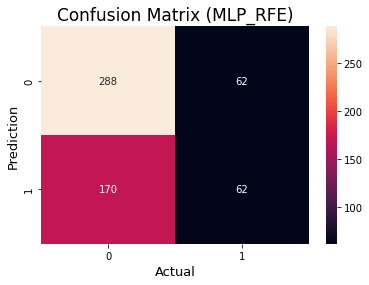

In [112]:
# confusion matrix
cm_mlp_rfe = confusion_matrix(y_test, y_pred_mlp_rfe)

#Plot the confusion matrix.
sns.heatmap(cm_mlp_rfe,
            annot=True,
            fmt='g',
            xticklabels=['0','1'],
            yticklabels=['0','1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix (MLP_RFE)',fontsize=17)
plt.show()

In [113]:
print(classification_report(y_test, y_pred_mlp_rfe, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.63      0.82      0.71       350
           1       0.50      0.27      0.35       232

    accuracy                           0.60       582
   macro avg       0.56      0.55      0.53       582
weighted avg       0.58      0.60      0.57       582



#### BorutaSHAP

In [114]:
from BorutaShap import BorutaShap

# If no model is selected default is the Random Forest
# If classification is True it is a classification problem
fs_bShap = BorutaShap(importance_measure='shap', classification=True)

fs_bShap.fit(X=X_train, y=y_train, n_trials=80, random_state=123)

  0%|          | 0/80 [00:00<?, ?it/s]

11 attributes confirmed important: ['type.of.heart.failure', 'chloride', 'left.ventricular.end.diastolic.diameter.LV', 'mean.corpuscular.volume', 'urea', 'cholesterol', 'D.dimer', 'high.sensitivity.troponin', 'systolic.blood.pressure', 'mean.hemoglobin.volume', 'sodium']
99 attributes confirmed unimportant: ['glomerular.filtration.rate', 'direct.bilirubin', 'body.temperature', 'coefficient.of.variation.of.red.blood.cell.distribution.width', 'indirect.bilirubin', 'fibrinogen', 'globulin', 'dementia', 'neutrophil.ratio', 'triglyceride', 'nucleotidase', 'monocyte.ratio', 'mean.platelet.volume', 'peripheral.vascular.disease', 'lactate.dehydrogenase', 'hydroxybutyrate.dehydrogenase', 'discharge.department', 'solid.tumor', 'weight', 'carbon.dioxide.binding.capacity', 'hemoglobin', 'fio2', 'platelet.distribution.width', 'basophil.ratio', 'glutamyltranspeptidase', 'verbal.response', 'myocardial.infarction', 'prothrombin.time.ratio', 'potassium', 'Killip.grade', 'outcome.during.hospitalization'

In [115]:
# as 5 attributes are still undecided we have two choices
# increase the n_trials or use the TentativeRoughFix()
fs_bShap.TentativeRoughFix()

0 tentative features are now accepted: []
5 tentative features are now rejected: ['thrombin.time' 'dischargeDay' 'cystatin' 'creatinine.enzymatic.method'
 'low.density.lipoprotein.cholesterol']


In [116]:
sel_feat_bShap = fs_bShap.Subset().columns
sel_feat_bShap

Index(['type.of.heart.failure', 'chloride',
       'left.ventricular.end.diastolic.diameter.LV', 'mean.corpuscular.volume',
       'urea', 'cholesterol', 'D.dimer', 'high.sensitivity.troponin',
       'systolic.blood.pressure', 'mean.hemoglobin.volume', 'sodium'],
      dtype='object')

In [117]:
# creating new versions of the train and test set using the selected
X_train_v5, X_test_v5 = X_train[sel_feat_bShap], X_test[sel_feat_bShap]

X_train_v5.shape, X_test_v5.shape

((1355, 11), (582, 11))

##### Re-training the models (BorutaSHAP)

In [118]:
# DT Classifier
clf_dt_bs = DecisionTreeClassifier(random_state=123)

clf_dt_bs.fit(X_train_v5, y_train)

y_pred_dt_bs = clf_dt_bs.predict(X_test_v5)

# evaluation
acc_dt_bs = accuracy_score(y_test, y_pred_dt_bs)
f1_dt_bs = f1_score(y_test, y_pred_dt_bs)

acc_dt_bs, f1_dt_bs

(0.5463917525773195, 0.45228215767634855)

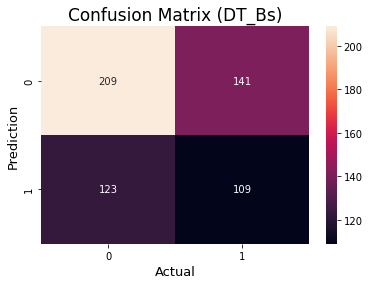

In [119]:
# confusion matrix
cm_dt_bs = confusion_matrix(y_test, y_pred_dt_bs)

#Plot the confusion matrix.
sns.heatmap(cm_dt_bs,
            annot=True,
            fmt='g',
            xticklabels=['0','1'],
            yticklabels=['0','1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix (DT_Bs)',fontsize=17)
plt.show()

In [120]:
print(classification_report(y_test, y_pred_dt_bs, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.63      0.60      0.61       350
           1       0.44      0.47      0.45       232

    accuracy                           0.55       582
   macro avg       0.53      0.53      0.53       582
weighted avg       0.55      0.55      0.55       582



In [121]:
# RandomForest Classifier
clf_rf_bs = RandomForestClassifier(random_state=123)

clf_rf_bs.fit(X_train_v5, y_train)

y_pred_rf_bs = clf_rf_bs.predict(X_test_v5)

# evaluation
acc_rf_bs = accuracy_score(y_test, y_pred_rf_bs)
f1_rf_bs = f1_score(y_test, y_pred_rf_bs)

acc_rf_bs, f1_rf_bs

(0.6305841924398625, 0.40443213296398894)

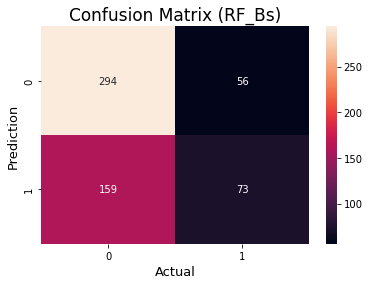

In [122]:
# confusion matrix
cm_rf_bs = confusion_matrix(y_test, y_pred_rf_bs)

#Plot the confusion matrix.
sns.heatmap(cm_rf_bs,
            annot=True,
            fmt='g',
            xticklabels=['0','1'],
            yticklabels=['0','1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix (RF_Bs)',fontsize=17)
plt.show()

In [123]:
print(classification_report(y_test, y_pred_rf_bs, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.65      0.84      0.73       350
           1       0.57      0.31      0.40       232

    accuracy                           0.63       582
   macro avg       0.61      0.58      0.57       582
weighted avg       0.62      0.63      0.60       582



In [124]:
# GBClassifier
clf_gb_bs = GradientBoostingClassifier(random_state=123)

clf_gb_bs.fit(X_train_v5, y_train)
y_pred_gb_bs = clf_gb_bs.predict(X_test_v5)

# evaluation
acc_gb_bs = accuracy_score(y_test, y_pred_gb_bs)
f1_gb_bs = f1_score(y_test, y_pred_gb_bs)

acc_gb_bs, f1_gb_bs

(0.6151202749140894, 0.422680412371134)

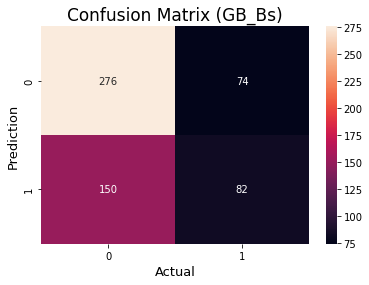

In [125]:
# confusion matrix
cm_gb_bs = confusion_matrix(y_test, y_pred_gb_bs)

#Plot the confusion matrix.
sns.heatmap(cm_gb_bs,
            annot=True,
            fmt='g',
            xticklabels=['0','1'],
            yticklabels=['0','1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix (GB_Bs)',fontsize=17)
plt.show()

In [126]:
print(classification_report(y_test, y_pred_gb_bs, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.65      0.79      0.71       350
           1       0.53      0.35      0.42       232

    accuracy                           0.62       582
   macro avg       0.59      0.57      0.57       582
weighted avg       0.60      0.62      0.60       582



In [127]:
# MLPClassifier
clf_mlp_bs = MLPClassifier(random_state=123)

clf_mlp_bs.fit(X_train_v5, y_train)

y_pred_mlp_bs = clf_mlp_bs.predict(X_test_v5)

# evaluation
acc_mlp_bs = accuracy_score(y_test, y_pred_mlp_bs)
f1_mlp_bs = f1_score(y_test, y_pred_mlp_bs)

acc_mlp_bs, f1_mlp_bs

(0.6185567010309279, 0.418848167539267)

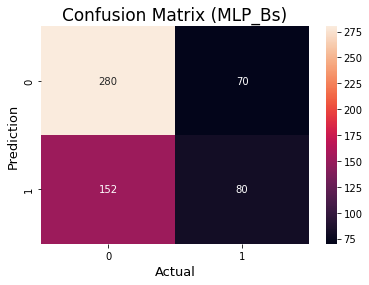

In [128]:
# confusion matrix
cm_mlp_bs = confusion_matrix(y_test, y_pred_mlp_bs)

#Plot the confusion matrix.
sns.heatmap(cm_mlp_bs,
            annot=True,
            fmt='g',
            xticklabels=['0','1'],
            yticklabels=['0','1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix (MLP_Bs)',fontsize=17)
plt.show()

In [129]:
print(classification_report(y_test, y_pred_mlp_bs, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.65      0.80      0.72       350
           1       0.53      0.34      0.42       232

    accuracy                           0.62       582
   macro avg       0.59      0.57      0.57       582
weighted avg       0.60      0.62      0.60       582



#### Boruta-SHAP for XGBM

In [130]:
from shaphypetune import BoostBoruta

In [131]:
from xgboost import XGBClassifier
### BORUTA-SHAP for LGBM & XGBM ###
clf_xgb = XGBClassifier()
model_bs = BoostBoruta(
    clf_xgb, max_iter=200, perc=80,
    importance_type='shap_importances', train_importance=False
)
model_bs.fit(X_train, y_train, eval_set=[(X_test, y_test)])

BoostBoruta(estimator=XGBClassifier(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                    

In [132]:
model_bs.n_features_

15

In [133]:
y_pred_bs1 = model_bs.predict(X_test)

In [134]:
# train & evaluation
acc_xgb_bs = accuracy_score(y_test, y_pred_bs1)
f1_xgb_bs = f1_score(y_test, y_pred_bs1)

acc_xgb_bs, f1_xgb_bs

(0.5996563573883161, 0.46924829157175396)

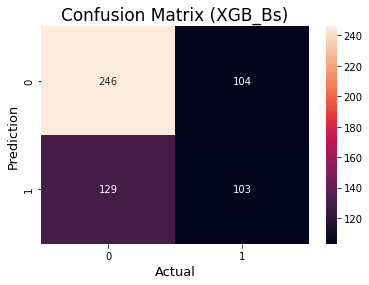

In [135]:
# confusion matrix
cm_xgb_bs = confusion_matrix(y_test, y_pred_bs1)

#Plot the confusion matrix.
sns.heatmap(cm_xgb_bs,
            annot=True,
            fmt='g',
            xticklabels=['0','1'],
            yticklabels=['0','1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix (XGB_Bs)',fontsize=17)
plt.show()

In [136]:
print(classification_report(y_test, y_pred_bs1, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.66      0.70      0.68       350
           1       0.50      0.44      0.47       232

    accuracy                           0.60       582
   macro avg       0.58      0.57      0.57       582
weighted avg       0.59      0.60      0.60       582



### Results Analysis

###### Analysis of Decision Tree Results

In [137]:
# dt results
results_dt = {
    "Accuracy": [acc_dt, acc_dt_corr, acc_dt_IG, acc_dt_vt, acc_dt_rfe, acc_dt_bs],
    "F1_Score": [f1_dt, f1_dt_corr, f1_dt_IG, f1_dt_vt, f1_dt_rfe, f1_dt_bs]
}

df_dt = pd.DataFrame(results_dt, index=['DT_Baseline', 'DT_Corr', 
                                     'DT_IG', 'DT_vt', 'DT_rfe', 'DT_bs'])
df_dt


,Accuracy,F1_Score
DT_Baseline,0.524055,0.411890
DT_Corr,0.577320,0.478814
DT_IG,0.510309,0.394904
DT_vt,0.534364,0.445808
DT_rfe,0.532646,0.435685
DT_bs,0.546392,0.452282


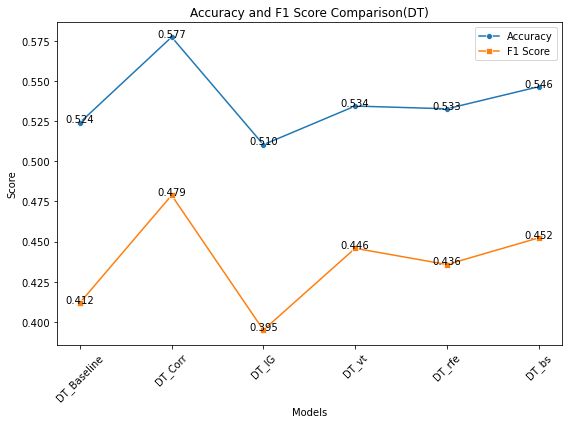

In [183]:
plt.figure(figsize=(8, 6))
ax_dt = sns.lineplot(data=df_dt, x=df_dt.index, y='Accuracy', marker='o', label='Accuracy')
ax_dt = sns.lineplot(data=df_dt, x=df_dt.index, y='F1_Score', marker='s', label='F1 Score')
# adding figures on each point
for index, row in df_dt.iterrows():
    ax_dt.text(row.name, row['Accuracy'], f"{row['Accuracy']:.3f}", color='black', ha="center")
    ax_dt.text(row.name, row['F1_Score'], f"{row['F1_Score']:.3f}", color='black', ha="center")
# customize labels and title
plt.xlabel('Models'), plt.ylabel('Score'), plt.title('Accuracy and F1 Score Comparison(DT)')
plt.xticks(rotation=45)
# display the legend
plt.legend()
# show the plot
plt.tight_layout()
plt.show()

###### Analysis of Random Forest Results

In [139]:
# rf results
results_knn = {
    "Accuracy": [acc_rf, acc_rf_corr, acc_rf_IG, acc_rf_vt, acc_rf_rfe, acc_rf_bs],
    "F1_Score": [f1_rf, f1_rf_corr, f1_rf_IG, f1_rf_vt, f1_rf_rfe, f1_rf_bs]
}

df_knn = pd.DataFrame(results_knn, index=['RF_Baseline', 'RF_Corr', 
                                     'RF_IG', 'RF_vt', 'RF_rfe', 'RF_bs'])
df_knn


,Accuracy,F1_Score
RF_Baseline,0.625430,0.369942
RF_Corr,0.635739,0.357576
RF_IG,0.630584,0.365782
RF_vt,0.632302,0.351515
RF_rfe,0.632302,0.335404
RF_bs,0.630584,0.404432


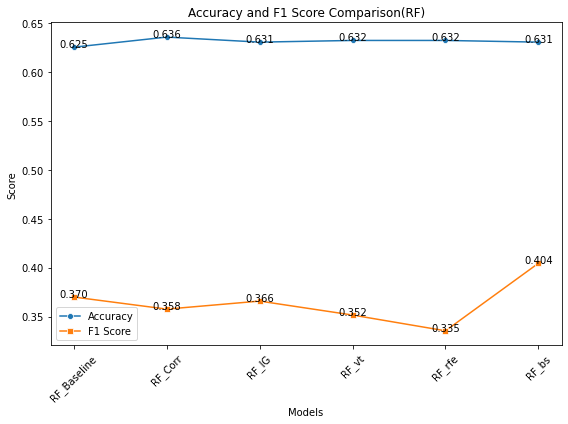

In [184]:
plt.figure(figsize=(8, 6))
ax_knn = sns.lineplot(data=df_knn, x=df_knn.index, y='Accuracy', marker='o', label='Accuracy')
ax_knn = sns.lineplot(data=df_knn, x=df_knn.index, y='F1_Score', marker='s', label='F1 Score')
# adding figures on each point
for index, row in df_knn.iterrows():
    ax_knn.text(row.name, row['Accuracy'], f"{row['Accuracy']:.3f}", color='black', ha="center")
    ax_knn.text(row.name, row['F1_Score'], f"{row['F1_Score']:.3f}", color='black', ha="center")
# customize labels and title
plt.xlabel('Models'), plt.ylabel('Score')
plt.title('Accuracy and F1 Score Comparison(RF)')
plt.xticks(rotation=45)
# display the legend & show the plot
plt.legend()
plt.tight_layout()
plt.show()

###### Analysis of Gradient Boosting Results

In [141]:
# gb results
results_gb = {
    "Accuracy": [acc_gb, acc_gb_corr, acc_gb_IG, acc_gb_vt, acc_gb_rfe, acc_gb_bs],
    "F1_Score": [f1_gb, f1_gb_corr, f1_gb_IG, f1_gb_vt, f1_gb_rfe, f1_gb_bs]
}

df_gb = pd.DataFrame(results_gb, index=['GB_Baseline', 'GB_Corr', 
                                     'GB_IG', 'GB_vt', 'GB_rfe', 'GB_bs'])
df_gb


,Accuracy,F1_Score
GB_Baseline,0.621993,0.430052
GB_Corr,0.628866,0.440415
GB_IG,0.644330,0.475949
GB_vt,0.609966,0.419437
GB_rfe,0.627148,0.439276
GB_bs,0.615120,0.422680


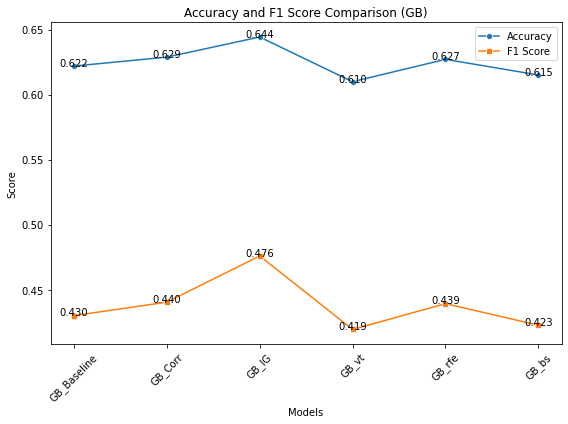

In [185]:
plt.figure(figsize=(8, 6))
ax_gb = sns.lineplot(data=df_gb, x=df_gb.index, y='Accuracy', marker='o', label='Accuracy')
ax_gb = sns.lineplot(data=df_gb, x=df_gb.index, y='F1_Score', marker='s', label='F1 Score')
# adding figures on each point
for index, row in df_gb.iterrows():
    ax_gb.text(row.name, row['Accuracy'], f"{row['Accuracy']:.3f}", color='black', ha="center")
    ax_gb.text(row.name, row['F1_Score'], f"{row['F1_Score']:.3f}", color='black', ha="center")
# customize labels and title
plt.xlabel('Models'), plt.ylabel('Score')
plt.title('Accuracy and F1 Score Comparison (GB)'), plt.xticks(rotation=45)
# display the legend
plt.legend()
# display the plot
plt.tight_layout()
plt.show()

###### Analysis of MLP Results

In [143]:
# mlp results
results_mlp = {
    "Accuracy": [acc_mlp, acc_mlp_corr, acc_mlp_IG, acc_mlp_vt, acc_mlp_rfe, acc_mlp_bs],
    "F1_Score": [f1_mlp, f1_mlp_corr, f1_mlp_IG, f1_mlp_vt, f1_mlp_rfe, f1_mlp_bs]
}

df_mlp = pd.DataFrame(results_mlp, index=['MLP_Baseline', 'MLP_Corr', 
                                     'MLP_IG', 'MLP_vt', 'MLP_rfe', 'MLP_bs'])
df_mlp


,Accuracy,F1_Score
MLP_Baseline,0.615120,0.440000
MLP_Corr,0.621993,0.481132
MLP_IG,0.615120,0.488584
MLP_vt,0.621993,0.497717
MLP_rfe,0.601375,0.348315
MLP_bs,0.618557,0.418848


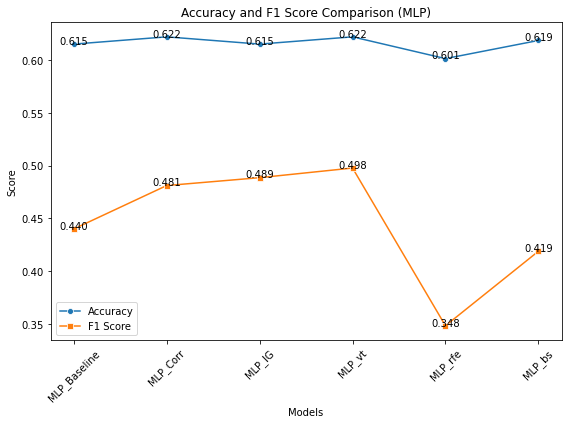

In [186]:
plt.figure(figsize=(8, 6))
ax_mlp = sns.lineplot(data=df_mlp, x=df_mlp.index, y='Accuracy', marker='o', label='Accuracy')
ax_mlp = sns.lineplot(data=df_mlp, x=df_mlp.index, y='F1_Score', marker='s', label='F1 Score')
# Adding figures on each point
for index, row in df_mlp.iterrows():
    ax_mlp.text(row.name, row['Accuracy'], f"{row['Accuracy']:.3f}", color='black', ha="center")
    ax_mlp.text(row.name, row['F1_Score'], f"{row['F1_Score']:.3f}", color='black', ha="center")
# Customize labels and title
plt.xlabel('Models'), plt.ylabel('Score'), plt.title('Accuracy and F1 Score Comparison (MLP)')
plt.xticks(rotation=45)
# Display the legend
plt.legend()
# Show the plot
plt.tight_layout()
plt.show()

##### Best Result combinations

In [163]:
# best combinations
results_best = {
    "Accuracy": [acc_mlp_corr, acc_mlp_vt, acc_gb_corr, acc_gb_rfe, acc_gb_IG, acc_dt_corr, acc_rf_IG, acc_xgb_bs],
    "F1_Score": [f1_mlp_corr, f1_mlp_vt, f1_gb_corr, f1_gb_rfe, f1_gb_IG, f1_dt_corr, f1_rf_IG, f1_xgb_bs]
}

df_best = pd.DataFrame(results_best, index=['MLP_Corr', 
                                     'MLP_vt', 'GB_corr', 'GB_rfe', 'GB_ig', 'DT_corr', 'RF_ig', 'XGB_bs'])

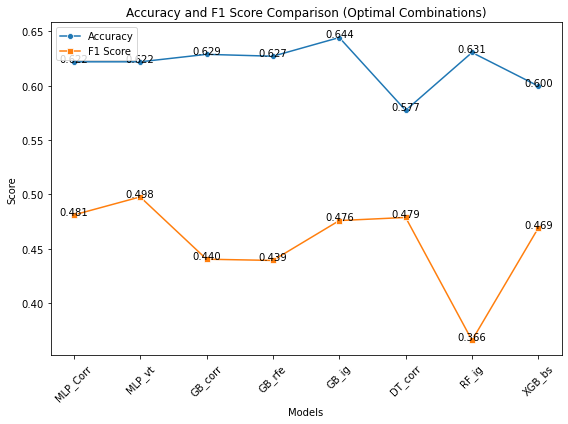

In [187]:
# visual aid
plt.figure(figsize=(8, 6))
ax_best = sns.lineplot(data=df_best, x=df_best.index, y='Accuracy', marker='o', label='Accuracy')
ax_best = sns.lineplot(data=df_best, x=df_best.index, y='F1_Score', marker='s', label='F1 Score')
# Adding figures on each point
for index, row in df_best.iterrows():
    ax_best.text(row.name, row['Accuracy'], f"{row['Accuracy']:.3f}", color='black', ha="center")
    ax_best.text(row.name, row['F1_Score'], f"{row['F1_Score']:.3f}", color='black', ha="center")
# Customize labels and title
plt.xlabel('Models'), plt.ylabel('Score')
plt.title('Accuracy and F1 Score Comparison (Optimal Combinations)'), plt.xticks(rotation=45)
# Display the legend
plt.legend()
# Show the plot
plt.tight_layout()
plt.show()

#### Discussion of the results
It is also worth noting that the effectiveness of these combinations depends on the specific dataset and the relationships between features and the target variable.

The gaps that could be further explored in future is the need for hyperparameter tuning on the models to obtain better results.
Also, the use of more complex models like black-box models could be better explored as there are feature attribution methods now available to better explain their results.

#### Conclusion
The following variables; admission ward, type of heart failure, NYHA cardiac function classification, diabetes, uric acid, mean hemoglobin volume, glomerular filtration rate, platelet count, basophil count, platelet hematocrit, D dimer, and discharge day were common variables alongside some other variables that were selected in all the feature selection techniques.

The findings could provide a reference for clinical care and decision making for heart failure patients in China and may also provide some value to heart failure re-admission studies in Asian populations. However, these selected features need to be vetted by healthcare and cardiology experts.